In [1]:
import pandas as pd

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [3]:
# Initial data inspection
train.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

In [4]:
# Calculate the number of unique values in each column
train.nunique()

Marital status                                       6
Application mode                                    22
Application order                                    8
Course                                              19
Daytime/evening attendance                           2
Previous qualification                              21
Previous qualification (grade)                     110
Nacionality                                         18
Mother's qualification                              35
Father's qualification                              39
Mother's occupation                                 40
Father's occupation                                 56
Admission grade                                    668
Displaced                                            2
Educational special needs                            2
Debtor                                               2
Tuition fees up to date                              2
Gender                                               2
Scholarshi

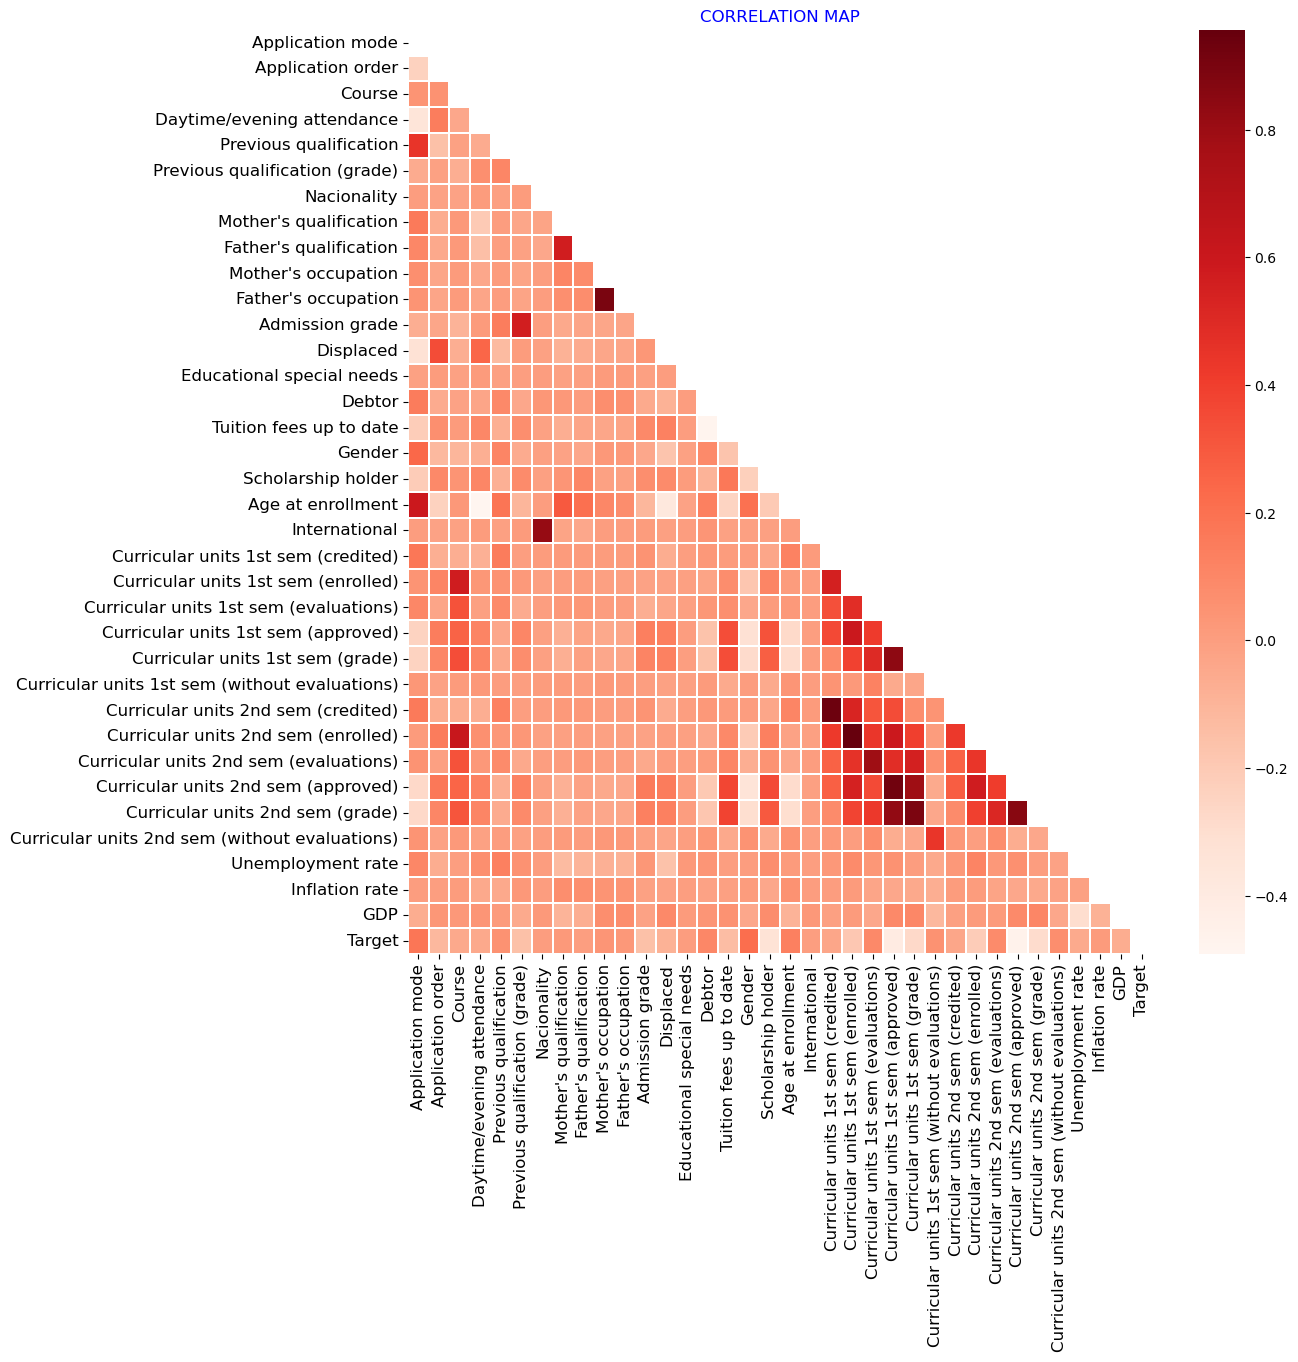

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##CORRELATION CHECK 
X=train[train.columns[1:-1]]
X['Target']=[1 if x=='Graduate' else 2 if x=='Dropout'else 3 for x in train['Target']]
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting correlation heatmap
fig,ax=plt.subplots(figsize=(12,12))
ax.set_xticklabels(labels=corr.columns,fontsize=12)
ax.set_yticklabels(labels=corr.columns,fontsize=12)
# plt.rcParams.update({'font.size': 12})
sns.heatmap(corr,mask=mask,cmap='Reds',linewidth=0.1)
plt.title('CORRELATION MAP',color='blue',fontsize=12)
plt.show()

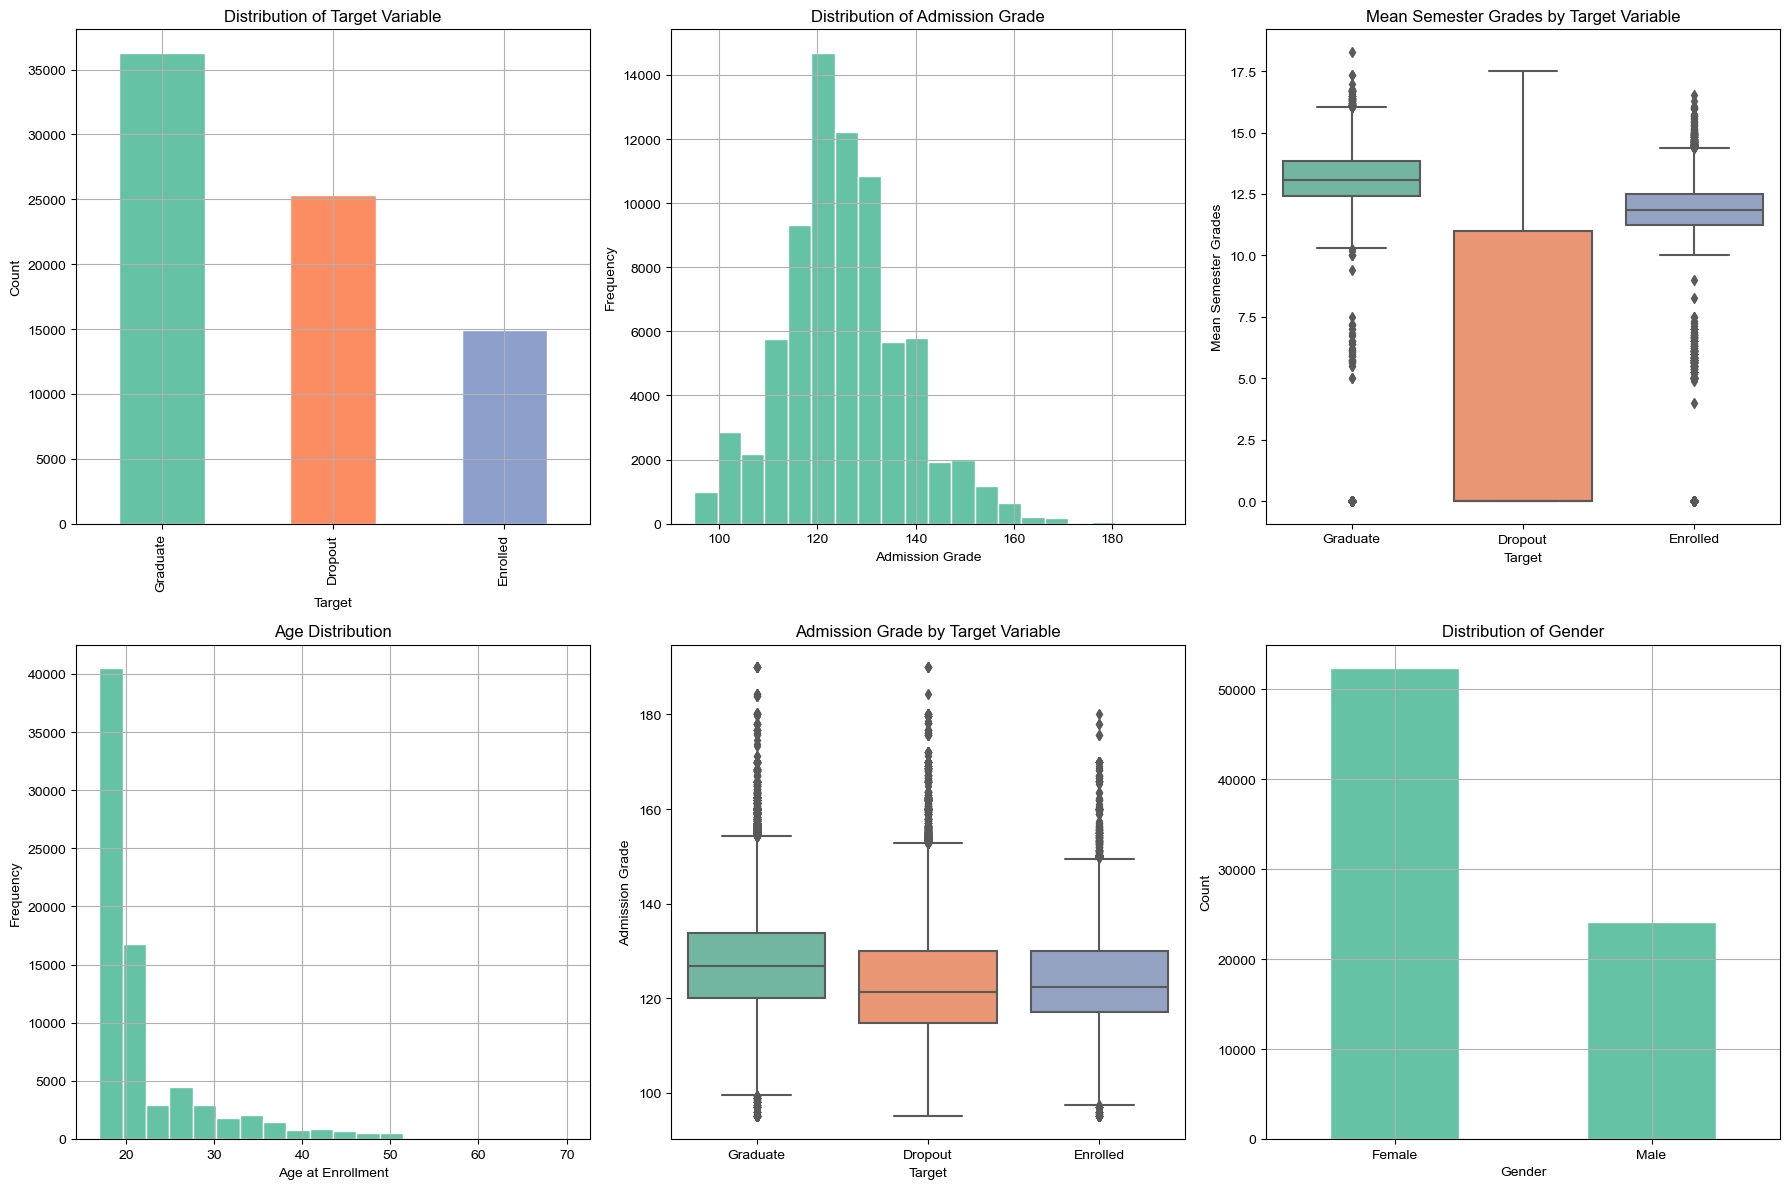

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a consistent color palette for the target categories using 'Set2'
palette = sns.color_palette("Set2", 3)
target_palette = {'Graduate': palette[0], 'Dropout': palette[1], 'Enrolled': palette[2]}

# Set up the figure and axes for multiple plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Set a common aesthetic for the plots
sns.set_style("whitegrid")

# Distribution of the target variable
train['Target'].value_counts().plot(kind='bar', ax=axes[0, 0], title='Distribution of Target Variable', color=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[0, 0].set_xlabel('Target')
axes[0, 0].set_ylabel('Count')

# Distribution of Admission Grade
train['Admission grade'].plot(kind='hist', bins=20, ax=axes[0, 1], title='Distribution of Admission Grade', color=palette[0])
axes[0, 1].set_xlabel('Admission Grade')
axes[0, 1].set_ylabel('Frequency')

# Calculate the mean semester grades
train['Mean Semester Grade'] = (train['Curricular units 1st sem (grade)'] + train['Curricular units 2nd sem (grade)']) / 2


# Distribution of Mean Semester Grades
sns.boxplot(x='Target', y='Mean Semester Grade', data=train, ax=axes[0, 2], palette=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[0, 2].set_title('Mean Semester Grades by Target Variable')
axes[0, 2].set_xlabel('Target')
axes[0, 2].set_ylabel('Mean Semester Grades')

# Age distribution
train['Age at enrollment'].plot(kind='hist', bins=20, ax=axes[1, 0], title='Age Distribution', color=palette[0])
axes[1, 0].set_xlabel('Age at Enrollment')
axes[1, 0].set_ylabel('Frequency')

# Box Plots for Admission Grades by Target Variable
sns.boxplot(x='Target', y='Admission grade', data=train, ax=axes[1, 1], palette=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[1, 1].set_title('Admission Grade by Target Variable')
axes[1, 1].set_xlabel('Target')
axes[1, 1].set_ylabel('Admission Grade')

# Distribution of gender
train['Gender'].value_counts().plot(kind='bar', ax=axes[1, 2], title='Distribution of Gender', color=palette[0])
axes[1, 2].set_xlabel('Gender')
axes[1, 2].set_xticklabels(['Female', 'Male'], rotation=0)
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

train = train.drop('Mean Semester Grade', axis=1)


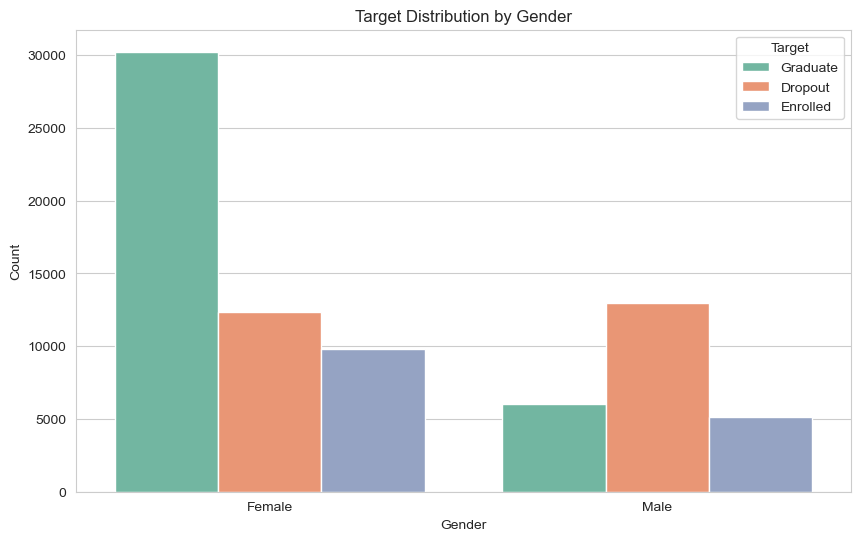

Chi-Square Test:
Chi2: 8342.754349629984
p-value: 0.0


In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Target', data=train, palette=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
plt.title('Target Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Target')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

from scipy.stats import chi2_contingency

# Example: Gender vs. Target
contingency_table = pd.crosstab(train['Gender'], train['Target'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f'Chi-Square Test:\nChi2: {chi2}\np-value: {p}')


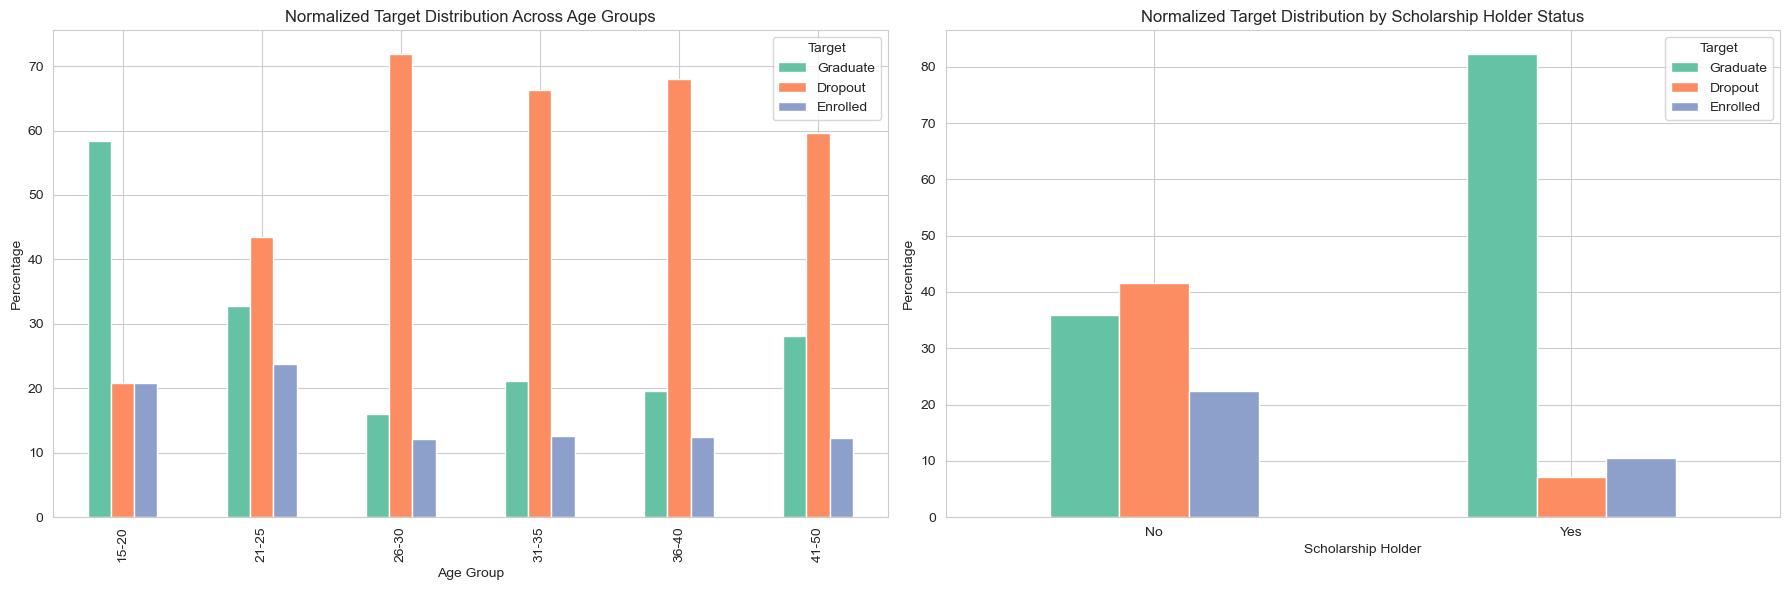

In [8]:
# Set up the figure for the normalized charts
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Age Group Analysis
train['Age Group'] = pd.cut(train['Age at enrollment'], bins=[15, 20, 25, 30, 35, 40, 50], labels=['15-20', '21-25', '26-30', '31-35', '36-40', '41-50'])

# Normalize the target distribution across age groups to percentages
age_group_distribution = train.groupby('Age Group')['Target'].value_counts(normalize=True).unstack().fillna(0) * 100
age_group_distribution = age_group_distribution[['Graduate', 'Dropout', 'Enrolled']]  # Ensure correct order
age_group_distribution.plot(kind='bar', ax=axes[0], color=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[0].set_title('Normalized Target Distribution Across Age Groups')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Target')

# Normalize the target distribution by scholarship holder status to percentages
scholarship_distribution = train.groupby('Scholarship holder')['Target'].value_counts(normalize=True).unstack().fillna(0) * 100
scholarship_distribution = scholarship_distribution[['Graduate', 'Dropout', 'Enrolled']]  # Ensure correct order
scholarship_distribution.plot(kind='bar', ax=axes[1], color=[target_palette['Graduate'], target_palette['Dropout'], target_palette['Enrolled']])
axes[1].set_title('Normalized Target Distribution by Scholarship Holder Status')
axes[1].set_xlabel('Scholarship Holder')
axes[1].set_ylabel('Percentage')
axes[1].set_xticklabels(['No', 'Yes'], rotation=0)
axes[1].legend(title='Target')

plt.tight_layout()
plt.show()

train = train.drop(['Age Group', ], axis=1)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine features
def combine_features(df):
    df['Total_Credits'] = df['Curricular units 1st sem (credited)'] + df['Curricular units 2nd sem (credited)']
    df['Total_Evaluations'] = df['Curricular units 1st sem (evaluations)'] + df['Curricular units 2nd sem (evaluations)']
    df['Total_Approved'] = df['Curricular units 1st sem (approved)'] + df['Curricular units 2nd sem (approved)']
    return df

train = combine_features(train)
test = combine_features(test)

# Verify the correct columns to remove
less_important_features = [
    'Marital status', 'Application mode', 'International', 'Mother\'s occupation',
    'Father\'s occupation', 'Educational special needs', 'Displaced', 'GDP',
    'Inflation rate', 'Unemployment rate'
]

train = train.drop(columns=less_important_features)
test = test.drop(columns=less_important_features)


In [10]:
from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(train.drop('Target', axis=1), train['Target'], test_size=0.2, random_state=42)

# Import The AUTO_ML
from flaml import AutoML

# Initlize The autoML
autoML = AutoML()
# Fit autoML on Data
autoML.fit(X_train, y_train, task="classification",metric='accuracy',time_budget=30)

print(f'Best AutoML Model: {autoML.best_estimator}\n')
print(f'Best Paramter AutoML Model:\n {autoML.best_config}\n')
print(f'Best roc_auc_ovo On Val data: {1 - autoML.best_loss:.4g}\n')
print(f'Best Run Training duration: {autoML.best_config_train_time:.4g} s\n')

# Feature importance
plt.figure(figsize=((20,15)), facecolor='yellow')  # Set background color to yellow
plt.barh(
    autoML.model.estimator.feature_name_, autoML.model.estimator.feature_importances_
)
plt.show()

ModuleNotFoundError: No module named 'flaml'

In [ ]:
from sklearn.metrics import accuracy_score 

# Predict on validation set
y_pred = autoML.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Best Accuracy on Validation Data: {accuracy:.4g}\n')

Best Accuracy on Validation Data: 0.8315



In [ ]:
# Separating the features into variables

target_feature = ['Target']

categorical_features = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"
]

binary_categorical_features = [
    'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]

numerical_features = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]


In [ ]:
# le = LabelEncoder()
# le.fit(train['Target'])
# train['Target'] = le.transform(train['Target'])

### Replace whitespaces with '_'

In [ ]:
# ##REMOVING WHITE SPACES FROM FEATURE NAMES
# df_train.columns=[x.replace(' ','_') for x in df_train.columns]
# df_test.columns=[x.replace(' ','_') for x in df_test.columns]

### Memory Optimization

In [ ]:
# #CHECKING TRAIN AND TEST DATASET MEMORY USAGE BEFORE DOWNCASTING
# print('\ntrain dataset data usage information before downcasting\n')
# df_train.info(memory_usage='deep',max_cols=1)
# print('\ntest dataset data usage information before downcasting\n')
# df_test.info(memory_usage='deep',max_cols=1)


# #DOWNCASTING TRAIN DATASET
# for column in df_train.columns:
#     if df_train[column].dtype == "float64":
#         df_train[column]=pd.to_numeric(df_train[column], downcast="float")
#     if df_train[column].dtype == "int64":
#         df_train[column]=pd.to_numeric(df_train[column], downcast="integer")
        
# #DOWNCASTING TEST DATASET
# for column in df_test.columns:
#     if df_test[column].dtype == "float64":
#         df_test[column]=pd.to_numeric(df_test[column], downcast="float")
#     if df_test[column].dtype == "int64":
#         df_test[column]=pd.to_numeric(df_test[column], downcast="integer")
        
# #CHECKING TRAIN AND TEST DATASET MEMORY USAGE AFTER DOWNCASTING
# print('train dataset data usage information after downcasting\n')
# df_train.info(memory_usage='deep',max_cols=1)
# print('\ntest dataset data usage information after downcasting\n')
# df_test.info(memory_usage='deep',max_cols=1)


## Feature Engineering Ideas
Based on these conclusions, here are some ideas for feature engineering:
1. **Balancing the Target Variable**: Implement techniques to handle class imbalance, such as SMOTE (Synthetic Minority Over-sampling Technique) or adjusting class weights during model training.
2. **Interaction Terms**: Create interaction terms between grades and demographic features to capture complex relationships.
3. **Normalized Grades**: Normalize grades to account for differences in grading scales or distributions.
4. **Age Groups**: Create age groups (bins) to capture trends related to non-traditional students.
5. **Gender-Specific Features**: Develop features that might capture gender-specific trends or behaviors in academic performance.
